In [98]:
import pandas as pd
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

from tqdm.auto import tqdm

In [ ]:
import requests

url = "https://github.com/alexeygrigorev/datasets/raw/refs/heads/master/jamb_exam_results.csv"
response = requests.get(url)

# Save the file
with open("jamb_exam_results.csv", "wb") as file:
    file.write(response.content)

In [28]:
df = pd.read_csv('jamb_exam_results.csv')
df.head(3)

,JAMB_Score,Study_Hours_Per_Week,Attendance_Rate,Teacher_Quality,Distance_To_School,School_Type,School_Location,Extra_Tutorials,Access_To_Learning_Materials,Parent_Involvement,IT_Knowledge,Student_ID,Age,Gender,Socioeconomic_Status,Parent_Education_Level,Assignments_Completed
0,192,22,78,4,12.4,Public,Urban,Yes,Yes,High,Medium,1,17,Male,Low,Tertiary,2
1,207,14,88,4,2.7,Public,Rural,No,Yes,High,High,2,15,Male,High,NaN,1
2,182,29,87,2,9.6,Public,Rural,Yes,Yes,High,Medium,3,20,Female,High,Tertiary,2


In [29]:
df.columns = df.columns.str.lower().str.replace(' ', '_')
df.drop(['student_id'], axis=1, inplace=True)
df.fillna(0, inplace=True)

In [62]:
from sklearn.model_selection import train_test_split

df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

In [63]:
y_train = df_train.jamb_score.values
y_val = df_val.jamb_score.values
y_test = df_test.jamb_score.values

df_train = df_train.drop(['jamb_score'], axis=1).reset_index(drop=True)
df_val = df_val.drop(['jamb_score'], axis=1).reset_index(drop=True)
df_test = df_test.drop(['jamb_score'], axis=1).reset_index(drop=True)

In [64]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.feature_extraction import DictVectorizer

In [65]:
dv = DictVectorizer(sparse=True)
train_dicts = df_train.to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

In [66]:
dt = DecisionTreeRegressor(max_depth=1)
dt.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=1)

In [67]:
feature_names=list(dv.get_feature_names_out())
X_train_df = pd.DataFrame(X_train.toarray(), columns = feature_names)

### Question 1. Most important featute

In [68]:
feature_importances = dt.feature_importances_
feature_importance_df = pd.DataFrame({
    'feature': X_train_df.columns,
    'importance': feature_importances
}).sort_values(by='importance', ascending=False)

print(feature_importance_df.head(2))

                             feature  importance
27              study_hours_per_week         1.0
1   access_to_learning_materials=Yes         0.0


### Question 2. Random forest RMSE

In [69]:
from sklearn.ensemble import RandomForestRegressor

In [71]:
rf = RandomForestRegressor(
    n_estimators=10,
    random_state=1,
    n_jobs=-1
    )

rf.fit(X_train, y_train)

RandomForestRegressor(n_estimators=10, n_jobs=-1, random_state=1)

In [74]:
from sklearn.metrics import root_mean_squared_error

X_val = dv.transform(df_val.to_dict(orient='records'))
y_pred = rf.predict(X_val)

rmse = root_mean_squared_error(y_val, y_pred)
rmse.round(3)

np.float64(42.137)

### Question 3. Number of estimators

In [103]:
scores = []

for n_estimator in range(10, 201, 10):
    print('n_estimator =', n_estimator, end = ': ')

    rf = RandomForestRegressor(
        n_estimators=n_estimator,
        random_state=1,
        n_jobs=-1
        )

    rf.fit(X_train, y_train)

    y_pred = rf.predict(X_val)

    rmse = root_mean_squared_error(y_val, y_pred)
    scores.append(rmse)
    print('rmse =', rmse.round(3))

n_estimator = 10: rmse = 42.137
n_estimator = 20: rmse = 41.461
n_estimator = 30: rmse = 41.106
n_estimator = 40: rmse = 40.917
n_estimator = 50: rmse = 40.852
n_estimator = 60: rmse = 40.784
n_estimator = 70: rmse = 40.677
n_estimator = 80: rmse = 40.539
n_estimator = 90: rmse = 40.504
n_estimator = 100: rmse = 40.517
n_estimator = 110: rmse = 40.593
n_estimator = 120: rmse = 40.625
n_estimator = 130: rmse = 40.651
n_estimator = 140: rmse = 40.595
n_estimator = 150: rmse = 40.597
n_estimator = 160: rmse = 40.604
n_estimator = 170: rmse = 40.628
n_estimator = 180: rmse = 40.641
n_estimator = 190: rmse = 40.631
n_estimator = 200: rmse = 40.601


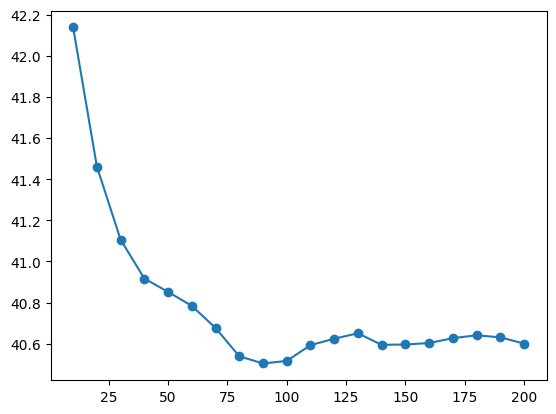

In [104]:
plt.plot(range(10, 201, 10), scores, marker='o')
plt.show()

### Question 4. Best max_depth

In [ ]:
max_depthes = [10, 15, 20, 25]
n_estimators = [i for i in range(10, 201, 10)]

for max_depth in tqdm(max_depthes):
    print('max_depth =', max_depth, end = ': ')
    scores = []

    for n_estimator in n_estimators:

        rf = RandomForestRegressor(
            n_estimators=n_estimator,
            max_depth = max_depth,
            random_state=1,
            n_jobs=-1
            )

        rf.fit(X_train, y_train)

        y_pred = rf.predict(X_val)

        rmse = root_mean_squared_error(y_val, y_pred)
        scores.append(rmse)
    print('mean rmse =', round(sum(scores) / len(scores), 3))
    print()


  0%|          | 0/4 [00:00<?, ?it/s]

max_depth = 10: mean rmse = 40.392

max_depth = 15: mean rmse = 40.735

max_depth = 20: mean rmse = 40.74

max_depth = 25: mean rmse = 40.788



### Question 5. Most important feature

In [107]:
rf = RandomForestRegressor(
        n_estimators=10,
        max_depth = 20,
        random_state=1,
        n_jobs=-1
        )

rf.fit(X_train, y_train)

feature_names=list(dv.get_feature_names_out())
X_train_df = pd.DataFrame(X_train.toarray(), columns = feature_names)

feature_importances = rf.feature_importances_
feature_importance_df = pd.DataFrame({
    'feature': X_train_df.columns,
    'importance': feature_importances
}).sort_values(by='importance', ascending=False)

print(feature_importance_df.head())

                 feature  importance
27  study_hours_per_week    0.248354
4        attendance_rate    0.149729
5     distance_to_school    0.136486
28       teacher_quality    0.082682
2                    age    0.069311


### Question 6. Eta for XGBoost

In [108]:
import xgboost as xgb

In [110]:
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=feature_names)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=feature_names)

watchlist = [(dtrain, 'train'), (dval, 'val')]

In [122]:
%%capture output

xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=100,
                  verbose_eval=5,
                  evals=watchlist)

In [123]:
y_pred = model.predict(dval)
root_mean_squared_error(y_val, y_pred)

np.float64(43.418817345871766)

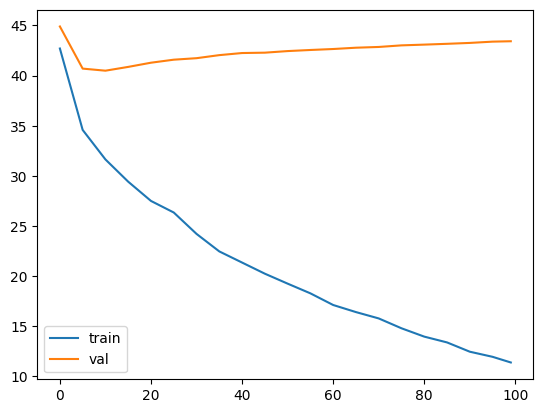

In [117]:
def parse_xgb_output(output):
    results = []

    for line in output.stdout.strip().split('\n'):
        it_line, train_line, val_line = line.split('\t')

        it = int(it_line.strip('[]'))
        train = float(train_line.split(':')[1])
        val = float(val_line.split(':')[1])

        results.append((it, train, val))
    
    columns = ['num_iter', 'train_auc', 'val_auc']
    df_results = pd.DataFrame(results, columns=columns)
    return df_results

df_score = parse_xgb_output(output)

plt.plot(df_score.num_iter, df_score.train_auc, label='train')
plt.plot(df_score.num_iter, df_score.val_auc, label='val')
plt.legend()
plt.show()

In [124]:
%%capture output

xgb_params = {
    'eta': 0.1, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=100,
                  verbose_eval=5,
                  evals=watchlist)

In [125]:
y_pred = model.predict(dval)
root_mean_squared_error(y_val, y_pred)

np.float64(41.05034017683498)

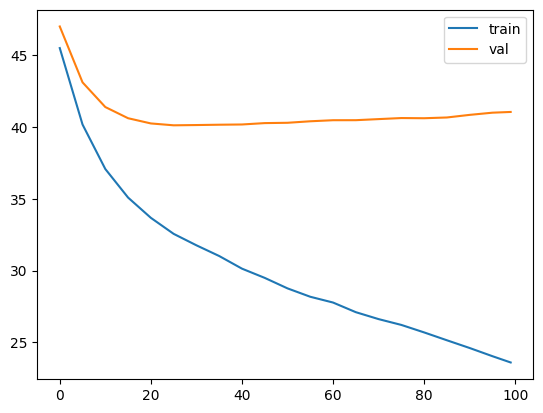

In [121]:
df_score = parse_xgb_output(output)

plt.plot(df_score.num_iter, df_score.train_auc, label='train')
plt.plot(df_score.num_iter, df_score.val_auc, label='val')
plt.legend()
plt.show()